# Final 2022 Fall

###### Created by Qihang Ma -- 2023.04.26

In [25]:
import warnings
warnings.filterwarnings("ignore")
from RiskLib import calculation, cov_matrix, linear_regression, optimal_portfolio, risk_attribution, risk_parity, Option, simulation, VaR
import pandas as pd
import numpy as np
import datetime as dt
from scipy.optimize import fsolve, minimize
import statsmodels.api as sm
from scipy.stats import t, norm, kurtosis, skew
import matplotlib.pyplot as plt

## Problem 1

Discuss the difference between Market, Credit, and Liquidity risks?


Market risk, credit risk, and liquidity risk are three types of risks that financial institutions and investors face. Here are the key differences between them:

1. Market Risk: Market risk is the risk of losses due to changes in market prices or values, such as fluctuations in interest rates, foreign exchange rates, or stock prices. Market risk affects the value of financial instruments, such as stocks, bonds, and derivatives, and can result in financial losses for investors.

2. Credit Risk: Credit risk is the risk of losses due to the failure of borrowers to repay their debts. This can occur when borrowers default on loans, bonds, or other financial instruments, leading to losses for lenders and investors.

3. Liquidity Risk: Liquidity risk is the risk of not being able to sell or buy a financial asset quickly enough or at a fair price to meet financial obligations. This can occur when there is a shortage of buyers or sellers, leading to a decline in market liquidity, or when there is a sudden need for cash due to unforeseen circumstances.

In summary, market risk relates to changes in market values, credit risk relates to the ability of borrowers to repay debts, and liquidity risk relates to the ability to sell or buy assets quickly and at a fair price. Financial institutions and investors must manage these risks to protect their investments and ensure financial stability.






# Problem 2

Assume, Risk Free = 4%, Implied Volatility=20%, Stock Price = 100, Strike Price=$90, No dividends are paid.

a. What are the value and greeks (Delta, Gamma, Vega,and Theta) of a short put with 30 days (365 total yearly days) until maturity?

b. After 5 days, assuming the price and implied volatility has not changed, what are the greeks for the same short put position?

In [26]:
S0 = 100
K = 90
ivol = 0.2
r = 0.04
T0 = 30/365

In [27]:
BuyingBS = Option.black_scholes_matrix(S0, K, T0, r, 0, ivol, 'put')
greeks = pd.DataFrame(BuyingBS.greeks(),index=['Short']) * -1
greeks 

,Value,Delta,Gamma,Vega,Theta,Rho,Carry Rho
Short,-0.060818,0.027206,-0.01094,-1.798386,2.076778,0.228614,0.223615


In [28]:
T1 = 25/365
five_days_later_BS = Option.black_scholes_matrix(S0, K, T1, r, 0, ivol, 'put')
greeks = pd.DataFrame(five_days_later_BS.greeks(),index=['Short(T+5)']) * -1
greeks 

,Value,Delta,Gamma,Vega,Theta,Rho,Carry Rho
Short(T+5),-0.035279,0.018245,-0.008555,-1.17198,1.6367,0.127383,0.124966


## Problem 3 

Use data in question3.csv. This is a simulation of prices 5 days forward for the underlying from Question 2.

a. Graph the dollar Profit and Loss from the short put position after these 5 days.

b. What is VaR and ES?

c. Discuss the risk versus return for this position.

In [29]:
price_after_5_days = pd.read_csv("question3.csv")
price_after_5_days['Value'] = price_after_5_days['fwdPrices'].apply(lambda x : Option.black_scholes(x, K, T1, r, 0, ivol, 'put'))
profit_and_loss = BuyingBS.price() -  price_after_5_days['Value']

In [30]:
profit_and_loss = np.array(BuyingBS.price() -  price_after_5_days['Value'])

In [31]:
Var = VaR.calculate_var(profit_and_loss)
ES = VaR.calculate_ES(profit_and_loss)

In [32]:
print("Mean: {:.6f}"  .format(np.mean(profit_and_loss)))
print("StDev: {:.6f}".format(np.std(profit_and_loss)))
print("Variance: {:.6f}" .format(np.var(profit_and_loss)))
print("Skew: {:.6f}"  .format(skew(profit_and_loss)))
print("Kurt: {:.6f}\n" .format(kurtosis(profit_and_loss)))
print("VaR: {:.6f}"  .format(Var))
print("ES: {:.6f}" .format(ES))

Mean: 0.014612
StDev: 0.056278
Variance: 0.003167
Skew: -3.649633
Kurt: 21.642387

VaR: 0.089816
ES: 0.169095


## Problem 4

Assume you own 3 stocks, GE, IBM, AMZN. Describe how you would attribute each stock’s contribution to ex-Ante risk.

1. Decide on an ex-Ante risk model.

2. Calculate the weight of each stock in the portfolio.

3. Calculate the gradient of risk wrt stocks.

4. Multiply each partial derivative with that stock's weight.

5. The result is the ex-ante contribution to risk.

## Problem 5

Use data in question5.csv.

  a. Plot the Autocorrelation and Partial Autocorrelation Functions.
  
  b. Is this data a Moving Average Process, Autoregressive Process, or neither. Why?
  
  c. If it is a MA or AR process, what is the order?

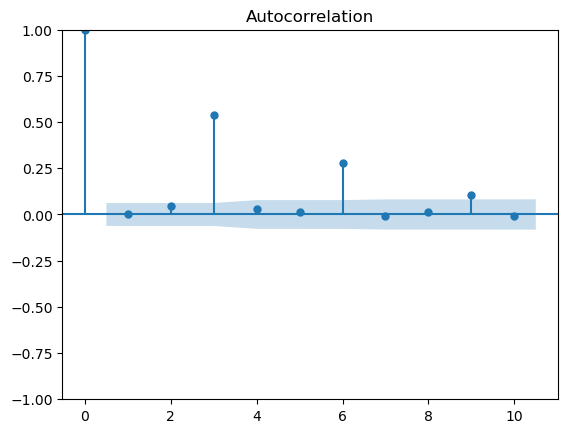

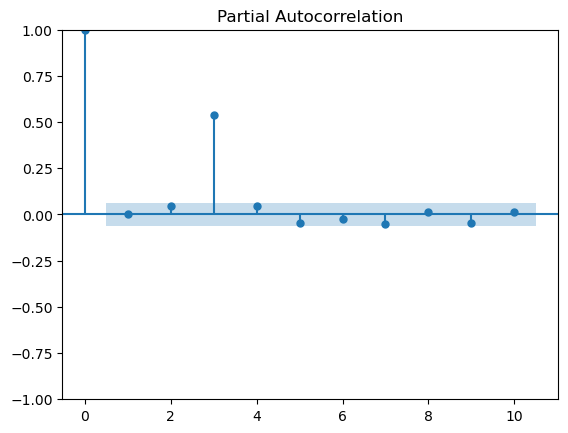

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load data
data = pd.read_csv("question5.csv")

# Plot Autocorrelation Function
plot_acf(data, lags=10)
plt.show()

# Plot Partial Autocorrelation Function
plot_pacf(data, lags=10)
plt.show()

This is an AR(3) process where the AR(1) and AR(2) betas are 0.  We can see from the PACF graph the only significant value is at lag=3.  The ACF has significant values at 3, 6, and 9.  These fall off in the typical pattern of an AR process. 

## Problem 6

Use data in question6.csv. You own 100 shares of AAPL and 100 shares of AMZN. You assume a structural model:

𝐴𝐴𝑃𝐿 =α1 +β1𝑆𝑃𝑌 + ε1

𝐴𝑀𝑍𝑁 = α2 +β2𝑆𝑃𝑌 +ε2

You assume the stock returns and SPY returns are normally distributed. ε1&ε2 are iid and
normally distributed (but not necessarily independent from each other).

Using this model, calculate the VaR of your portfolio.

In [34]:
all_price = pd.read_csv('question6.csv')
all_price

,Date,SPY,AMZN,AAPL
0,12/6/2021,451.951080,171.368500,164.366074
1,12/7/2021,461.299591,176.164505,170.192230
2,12/8/2021,462.521118,176.158005,174.069733
3,12/9/2021,459.398376,174.171005,173.552734
4,12/10/2021,463.722900,172.212006,178.414536
...,...,...,...,...
246,11/28/2022,395.910004,93.949997,144.220001
247,11/29/2022,395.230011,92.419998,141.169998
248,11/30/2022,407.679993,96.540001,148.029999
249,12/1/2022,407.380005,95.500000,148.309998


In [35]:
stocks = ['AMZN', 'AAPL']
returns = calculation.return_calculate(all_price[stocks+['Date']]).drop('Date', axis=1)

In [36]:
sim_return = pd.DataFrame(simulation.multivariate_normal_simulation(returns.cov(),10000, method = 'pca', mean = returns.mean(),seed=12), columns=stocks)

weights = all_price[stocks].tail(1).values/np.sum(all_price[stocks].tail(1).values)
portfolio_return = np.dot(sim_return, weights.T)

sim_price_change = 100 * np.dot(1 + sim_return, all_price[stocks].tail(1).T)

In [37]:
print ("VaR 95%: {:.6f}, $ {:.2f}" .format(VaR.calculate_var(portfolio_return, np.mean(portfolio_return)), VaR.calculate_var(sim_price_change, sim_price_change.mean())))
print ("VaR 99%: {:.6f}, $ {:.2f}" .format(VaR.calculate_var(portfolio_return, np.mean(portfolio_return),0.01), VaR.calculate_var(sim_price_change, sim_price_change.mean(),0.01)))

VaR 95%: 0.039046, $ 944.67
VaR 99%: 0.055112, $ 1333.39


## Problem 7 

Assume the have the same three variables and structural model as in Question #6. However, now
we assume that ε1&ε2 are iid and distributed by a generalized Student T distribution. 

Describe how you would calculate VaR.

1. fit the models to get the parameters and U values for the e1 and e2 variables.  Find the U values for SPY

2. Use the spearman correlation between the e1, e2, and SPY U values to fit the Gaussian copula.

3. Simulate from the copula and transform back to e1, e2, and SPY

4. use the fitted Alpha and Beta values to transform e1, e2, and X into AMZN and AAPL.

5. calculate the PnL for each simulations and calculate VaR

## Problem 8 

Compare and contrast Standard Deviation, Value at Risk, and Expected Shortfall as competing risk measures. Discuss different assumptions such as underlying distributions as well as applications affect where one might be preferred over another.

1. Standard Deviation and Expected Shortfall are coherent risk measures while VaR is not.

2. Standard Deviation assumes a Symmetric distribution of returns where VaR and ES do not.

3. VaR and ES do not rely on a symmetric distribution of returns and take into account higher moments.

4. If a normal distribution is assumed, then SD, VaR, and ES are equivilent with VaR and ES being a multiple of SD.

5. Most portfolio metrics assume normallity and as such use SD.

6. Breaking the normallity assumption for portfolio construction it is best to use ES as it is
coherent and convex, making the optimization easier to solve.

## Problem 9

Given 3 Assets, A, B, and C. The risk free rate is 4%. The correlation matrix is:

    3×3 Matrix{Float64}: 
            1.0 0.7 0.4
            0.7 1.0 0.6
            0.4 0.6 1.0

Volatilities are

3-element Vector{Float64}: 0.1 0.2 0.3

Expected Returns are

3-element Vector{Float64}: 0.05 0.07 0.09

What is the maximum sharpe ratio portfolio with no constraints on negative weights?

In [38]:
assets = ['A', 'B', 'C']
corel_matrix = np.array([[1.0, 0.7, 0.4],[0.7, 1.0, 0.6],[0.4, 0.6, 1.0]])
vol = np.array([0.1, 0.2, 0.3])
exp_return = np.array([0.05, 0.07, 0.09])

cov_matrix = pd.DataFrame(np.diag(vol) @ corel_matrix @ np.diag(vol), index=[assets], columns = [assets])

In [39]:
Optweight,_ = optimal_portfolio.Optweight_sr(assets, exp_return, cov_matrix, 0.04, (None, None))
Optweight

,Stock,Weight,cEr
0,A,-0.068301,-0.003415
1,B,0.541484,0.037904
2,C,0.526817,0.047414


## Problem 10

Given the covariance structure in #9,

a. What are the risk parity portfolio weights?

b. Discuss the differences between the portfolios found in #9 and #10.

In [40]:
vol_rp = risk_parity.vol_risk_parity(exp_return, cov_matrix)
vol_rp

,Weight,cEr,CSD
A,0.554199,0.027710,0.045892
B,0.254507,0.017816,0.045893
C,0.191293,0.017216,0.045892


In [41]:
rf = 0.04
w1 = Optweight['Weight'].values
w2 = vol_rp['Weight'].values

def portfolio_stats(weight, exp_return, rf):
    exp_return_portfolio = np.dot(weight, exp_return) 
    print("Expected Return: {:.6f}".format(exp_return_portfolio))
    std_portfolio = np.sqrt(np.dot(weight.T, np.dot(cov_matrix, weight)))
    print("Standard Deviation: {:.6f}".format(std_portfolio))
    sharp_ratio = (exp_return_portfolio - rf) /std_portfolio
    print("Sharp Ratio: {:.6f}\n".format(sharp_ratio))

print("For #9:")
portfolio_stats(w1, exp_return, rf)

print("For #10:")
portfolio_stats(w2, exp_return, rf)


For #9:
Expected Return: 0.081902
Standard Deviation: 0.235357
Sharp Ratio: 0.178037

For #10:
Expected Return: 0.062742
Standard Deviation: 0.137676
Sharp Ratio: 0.165184



## EC1

The file ec1_history.csv contains monthly returns for 3 stocks (S1, S2, and S3) and returns for 2 factors (F1 and F2). The risk free rate is 0.3% per month. Factors returns are in excess of the risk free rate however stock returns are not.

a. Calculate the factor Betas for each Stock.

b. The file ec1_fwd.csv contains a series of returns for both stocks and factors. 
 Assume the Alpha from the fitting above is 0. Assume you start the period holding with the stock
 weights as [0.3, 0.45, 0.25]. Attribute the realized excess return and standard deviation of the portfolio over the series to each factor. Report the residual as Portfolio Alpha.

In [42]:
dataset = pd.read_csv('ec1_history.csv')
stocks = ['S1', 'S2', 'S3']
factors = ['F1', 'F2']
rf = 0.003

#### Calculate Alpha and Beta

In [43]:
X = dataset[factors]
X = sm.add_constant(X)

y = dataset[stocks] - rf

betas = pd.DataFrame(index=stocks, columns=factors)
alphas = pd.DataFrame(index=stocks, columns=['Alpha'])


for stock in stocks:
    model = sm.OLS(y[stock], X).fit()
    betas.loc[stock] = model.params[factors]
    alphas.loc[stock] = model.params['const']

#### Fator Attribute

In [44]:
update_dataset = pd.read_csv('ec1_fwd.csv')
upreturn = update_dataset[stocks] - rf
upfactor = update_dataset[factors]

w = np.array([0.3, 0.45, 0.25])

risk_attribution.expost_factor(w, upreturn, upfactor, betas)

,Value,F1,F2,Alpha,Portfolio
0,TotalReturn,0.039390,-0.120548,0.009444,0.011677
1,Return Attribution,0.030095,-0.027778,0.009360,0.011677
0,Vol Attribution,0.016190,0.006065,0.001852,0.024107


## EC2

Using the data in ec2.csv.

    a. 𝑋~𝑁(μ, σ)
    b. 𝑌𝑖 =α𝑖 +β𝑖𝑋 +ε𝑖 𝑓𝑜𝑟 𝑖 ∈ [1,2]
    c. ε𝑖~𝑇(0,σ𝑖,ν𝑖)𝑓𝑜𝑟 𝑖 ∈ [1,2]
    d. Initial price of Y1 = $10.
    e. Initial price of Y2 = $50.
    f. You hold a portfolio of 100 shares of both Y1 and Y2
    
What is the VaR and ES of the portfolio, given the information above, expressed as a $ profit and loss?

In [45]:
dataset = pd.read_csv('ec2.csv')
dataset

,x,y1,y2
0,-0.012468,-0.016896,-0.010039
1,-0.031405,-0.037753,-0.024188
2,-0.035380,-0.046763,-0.030678
3,0.012044,0.013297,0.010900
4,-0.009185,-0.011777,-0.007490
...,...,...,...
95,0.011420,0.011105,0.009198
96,0.031483,0.035942,0.023253
97,-0.039932,-0.048971,-0.030514
98,0.016438,0.017747,0.012462


In [46]:
parameters_y1, error_y1 = linear_regression.fit_regression_t(dataset['y1'],dataset['x'])
parameters_y2, error_y2 = linear_regression.fit_regression_t(dataset['y2'],dataset['x'])

In [47]:
VaRs = []
ESs = []

for i in range(100):
    fitting_data  = pd.DataFrame({'error_y1': error_y1,
                                'error_y2': error_y2,
                                'X': dataset['x']})
    fitting_model = np.array(['t','t','n'])
    sim_return, p = simulation.gaussian_copula(fitting_data,fitting_model,seed=i)
    sim_return['y1'] = sim_return.apply(lambda x: x[2]*parameters_y1['beta']+parameters_y1['alpha']+x[0], axis=1)
    sim_return['y2'] = sim_return.apply(lambda x: x[2]*parameters_y2['beta']+parameters_y2['alpha']+x[1], axis=1)
    pnl = sim_return[['y1', 'y2']] @ np.array([10,50]) * 100
    VaRs.append(VaR.calculate_var(pnl))
    ESs.append(VaR.calculate_ES(pnl))
VaRs = np.array(VaRs)
ESs = np.array(ESs)

In [48]:
print("VaR Mean: {:.4f} -- 5% range [{:.4f}, {:.4f}].".format(VaRs.mean(), np.quantile(VaRs, 0.025), np.quantile(VaRs, 0.975)))
print("ES Mean: {:.4f} -- 5% range [{:.4f}, {:.4f}].".format(ESs.mean(), np.quantile(ESs, 0.025), np.quantile(ESs, 0.975)))

VaR Mean: 176.9358 -- 5% range [173.2143, 181.3280].
ES Mean: 219.3506 -- 5% range [214.7492, 223.6549].
